In [1]:
import os, sys
from glob import glob
sys.path.append("../")
sys.path.append('/Users/hongwan/GitHub/DarkHistory/')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from scipy.interpolate import interp1d, RegularGridInterpolator
from tqdm import *

import darkhistory.physics as phys
import darkhistory.history.tla_DP_DM_heating as tla

import pickle

from scipy.integrate import quad

from grf.grf import TransitionProbabilities, PerturbedProbability, FIRAS
from grf.units import *
from grf.pk_interp import PowerSpectrumGridInterpolator

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Load plot style

from plot_params import params
pylab.rcParams.update(params)

cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

/Users/hongwan/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/hongwan/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [3]:
# Non-linear matter power spectrum. 
pspec_nonlin_matter       = PowerSpectrumGridInterpolator("nonlin_matter")
# Non-linear baryon power spectrum from simulations, lower limit. 
pspec_nonlin_baryon_lower = PowerSpectrumGridInterpolator("franken_lower")
# Non-linear baryon power spectrum from simulations, upper limit. 
pspec_nonlin_baryon_upper = PowerSpectrumGridInterpolator("franken_upper")

In [4]:
# Class containing results with non-linear matter power spectrum. 
firas_nonlin            = FIRAS(pspec_nonlin_matter)
# Class containing results with non-linear baryon power spectrum from simulations, lower limit.
firas_nonlin_baryon_low = FIRAS(pspec_nonlin_baryon_lower)
# Class containing results with non-linear baryon power spectrum from simulations, upper limit. 
firas_nonlin_baryon_upp = FIRAS(pspec_nonlin_baryon_upper)

# Analytic PDF. 
log_analytic_pdf_interp = pickle.load(open('../data/analytic_pdf_grids/log_analytic_pdf_interp.npy', 'rb'))

In [5]:
def xe_reion_func(rs):
    # Parameters of the model.
    
    f = 1. + phys.chi
    delta_z = 0.7
    delta_eta = 1.5*rs**0.5*delta_z
    z_re = 8.8
    eta = rs**(3/2)
    eta_re = (1 + z_re)**(3/2)
    
    reion_model_xe = (f/2)*(1 + np.tanh((eta_re - eta)/delta_eta))
    
    return reion_model_xe

In [6]:
m_Ap = 1e-12 / 1e3

rs_vec = np.flipud(np.arange(20, 1600, 0.01))

soln_ary = []

soln_homo_ary = []

hmax = 0.1

def inj_rate(rs):

    return phys.rho_DM * rs**3 / np.abs(phys.dtdz(rs))

for eps in tqdm_notebook([5e-13, 1e-13, 3e-14, 2e-14]):

    homo_resonance_info = firas_nonlin_baryon_low.P_tot(
        [m_Ap], eps, m_Ap, evolve_z=False
    )
    
    z_res = homo_resonance_info[0][0]
    P_res = firas_nonlin_baryon_low.P_trans(
        m_Ap, z_res, m_Ap, eps, evolve_z=False 
    )
    
    print(z_res, P_res)
    
    def f_heating_homo(rs, xHI, xHeI, xHeII):
        
        sigma = 0.5
        
        dP_dz = 0.
        
        for z,P in zip(z_res, P_res):
            
            dP_dz += P/np.sqrt(2*np.pi*sigma**2) * np.exp(-(rs - (1. + z))**2 / (2*sigma**2))
        
        return dP_dz 
    
    res_homo = tla.get_history(
        rs_vec, f_heating=f_heating_homo, injection_rate=inj_rate, 
        reion_switch=True, xe_reion_func=xe_reion_func, reion_rs=13, hmax=0.2,
        coll_ion=True
    )
    
    soln_homo_ary.append(res_homo)
    
    def f_heating(rs, xHI, xHeI, xHeII):

        dP_dz = firas_nonlin_baryon_low._dP_dz(
            [rs-1.], m_Ap, k_min=1e-4, k_max=1e4, omega=[m_Ap], 
            x_e_ary=np.array([1. - xHI]),
            pdf = 'lognormal', one_plus_delta_bound=1e2, 
            Ap_DM = True, eng_weight=True
        )[0][0][0] * eps**2

#         print(rs, dP_dz)

        return dP_dz

    res = tla.get_history(
        rs_vec, f_heating=f_heating, injection_rate=inj_rate, 
        reion_switch=True, xe_reion_func=xe_reion_func, reion_rs=13, hmax=hmax,
        coll_ion=True
    )
    
    soln_ary.append(res)
    

std = tla.get_history(rs_vec, reion_switch=True, xe_reion_func=xe_reion_func, heat_switch=False, reion_rs=13)

[210.04681136] [8.99518591e-08]
[210.04681136] [3.59807437e-09]
[210.04681136] [3.23826693e-10]
[210.04681136] [1.43922975e-10]



In [7]:
std_optical_depth = phys.get_optical_depth(np.flipud(rs_vec), np.flipud(std[:,1]))

0.14615267553467248
0.045540012728032764
0.00443687665106296
0.0001312957854651131


[20, 200, 0.0001, 2]

/Users/hongwan/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/hongwan/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/hongwan/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/hongwan/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


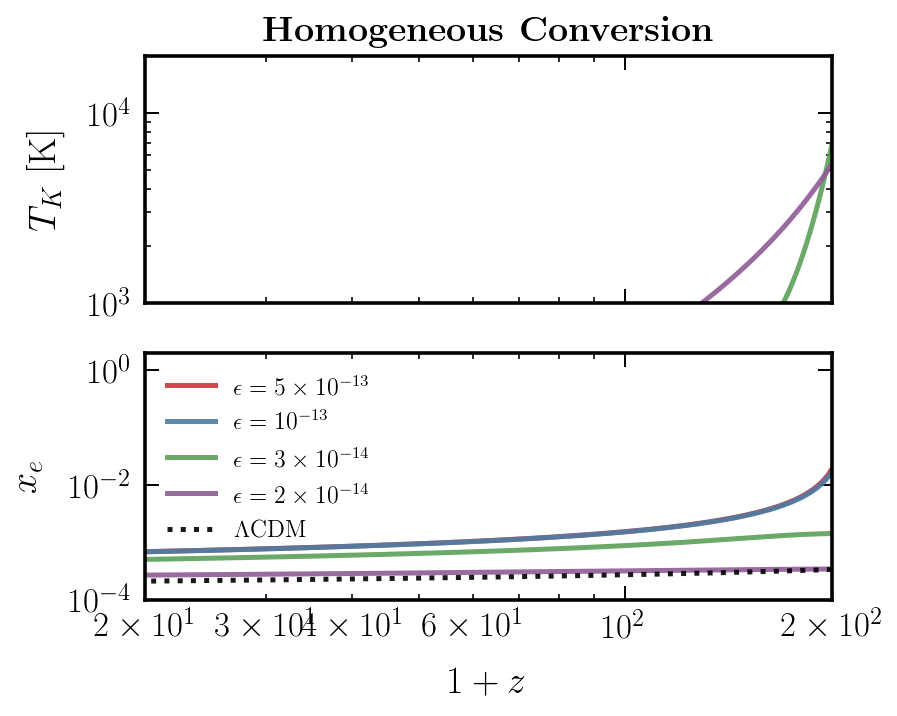

In [8]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.loglog()

plt_labels=[
    r'$\epsilon = 5 \times 10^{-13}$', r'$\epsilon = 10^{-13}$', 
    r'$\epsilon = 3 \times 10^{-14}$', r'$\epsilon = 2 \times 10^{-14}$'
]

for soln,label in zip(soln_homo_ary, plt_labels):
    ax1.plot(rs_vec, soln[:,0]/phys.kB, label=label)
    
ax1.plot(rs_vec, std[:,0]/phys.kB, 'k:', label=r'$\Lambda$CDM')

ax1.set_ylabel(r'$T_K$ [K]')

ax1.axis([20, 200, 1e3, 2e4])

ax1.set_title(r'\textbf{Homogeneous Conversion}')

ax2.loglog()

for soln,label in zip(soln_homo_ary, plt_labels):
    ax2.plot(rs_vec, soln[:,1], label=label)
    print(phys.get_optical_depth(np.flipud(rs_vec), np.flipud(soln[:,1])) - std_optical_depth)
ax2.plot(rs_vec, std[:,1], 'k:', label=r'$\Lambda$CDM')

ax2.set_xlabel(r'$1+z$')
ax2.set_ylabel(r'$x_e$')

ax2.legend(fontsize=12)

ax2.axis([20, 200, 1e-4, 2])

0.2026138195399625
0.1539650902459968
0.10613386013237402
0.00014407906792257563


[20, 200, 0.0001, 2]

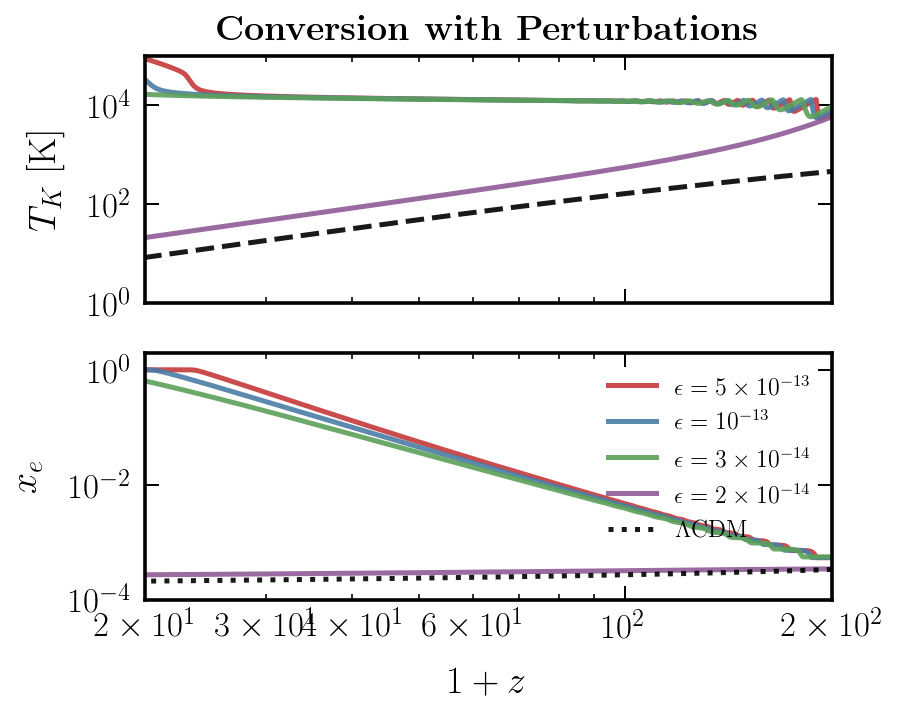

In [9]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.loglog()

plt_labels=[
    r'$\epsilon = 5 \times 10^{-13}$', r'$\epsilon = 10^{-13}$', 
    r'$\epsilon = 3 \times 10^{-14}$', r'$\epsilon = 2 \times 10^{-14}$'
]

for soln,label in zip(soln_ary, plt_labels):
    ax1.plot(rs_vec, soln[:,0]/phys.kB, label=label)
    
ax1.set_title(r'\textbf{Conversion with Perturbations}')
    
ax1.plot(rs_vec, std[:,0]/phys.kB, 'k--', label=r'$\Lambda$CDM')

ax1.set_ylabel(r'$T_K$ [K]')

ax1.axis([20, 200, 1, 1e5])

ax2.loglog()

for soln,label in zip(soln_ary, plt_labels):
    ax2.plot(rs_vec, soln[:,1], label=label)
    print(phys.get_optical_depth(np.flipud(rs_vec), np.flipud(soln[:,1])) - std_optical_depth)
ax2.plot(rs_vec, std[:,1], 'k:', label=r'$\Lambda$CDM')

plt.xlabel(r'$1+z$')
plt.ylabel(r'$x_e$')

plt.legend(fontsize=12, loc='upper right')

ax2.axis([20, 200, 1e-4, 2])

0.14615267553467248
0.045540012728032764
0.00443687665106296
0.0001312957854651131


[20, 1600, 1, 100000.0]

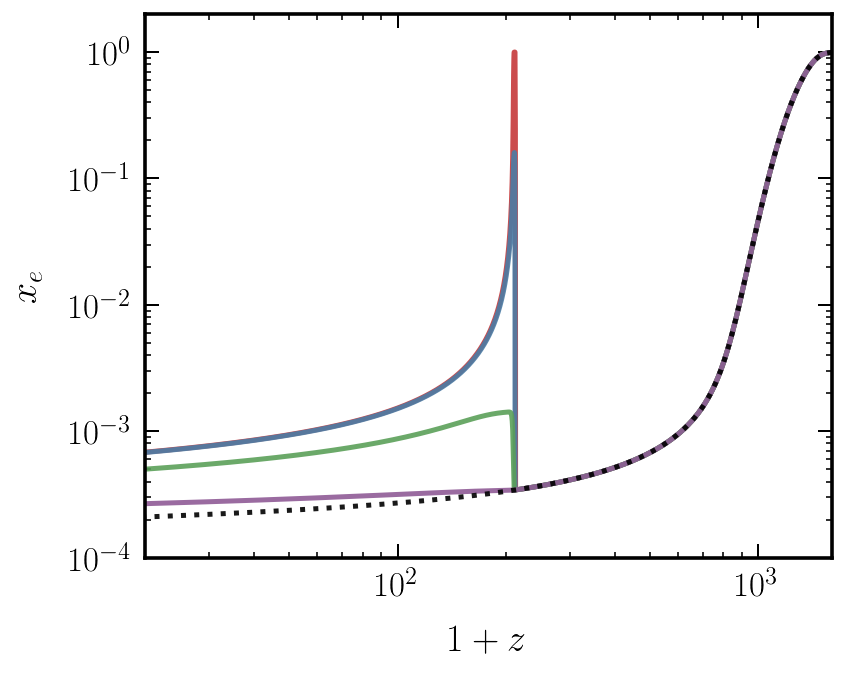

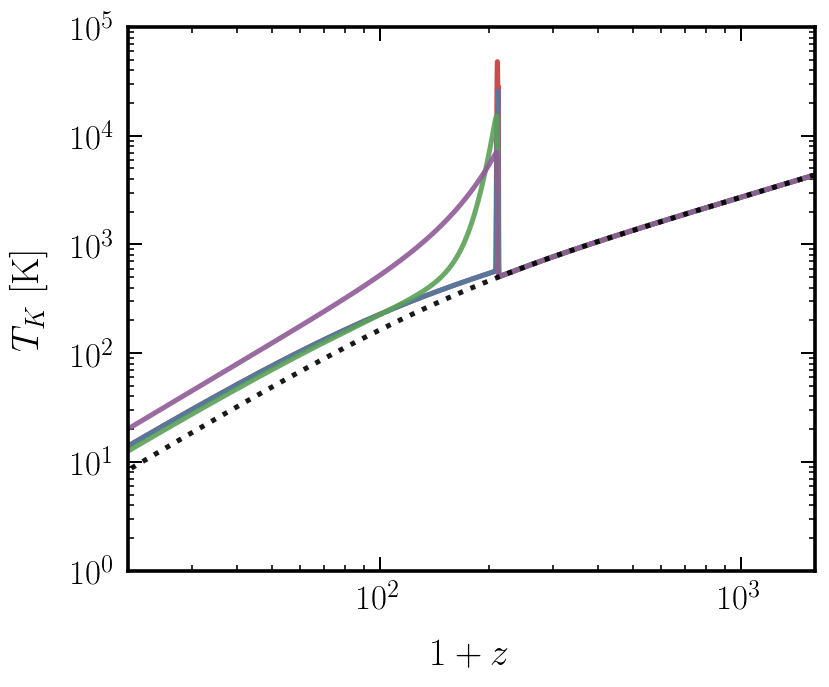

In [10]:
plt.figure()

ax2 = plt.gca()

ax2.loglog()

for soln in soln_homo_ary:
    ax2.plot(rs_vec, soln[:,1])
    print(phys.get_optical_depth(np.flipud(rs_vec), np.flipud(soln[:,1])) - std_optical_depth)
ax2.plot(rs_vec, std[:,1], 'k:')

plt.xlabel(r'$1+z$')
plt.ylabel(r'$x_e$')

ax2.axis([20, 1600, 1e-4, 2])

plt.figure()

ax2 = plt.gca()

ax2.loglog()

for soln in soln_homo_ary:
    ax2.plot(rs_vec, soln[:,0]/phys.kB)
ax2.plot(rs_vec, std[:,0]/phys.kB, 'k:')

plt.xlabel(r'$1+z$')
plt.ylabel(r'$T_K$ [K]')

ax2.axis([20, 1600, 1, 1e5])

0.2026138195399625
0.1539650902459968
0.10613386013237402
0.00014407906792257563


[20, 1600, 1, 100000.0]

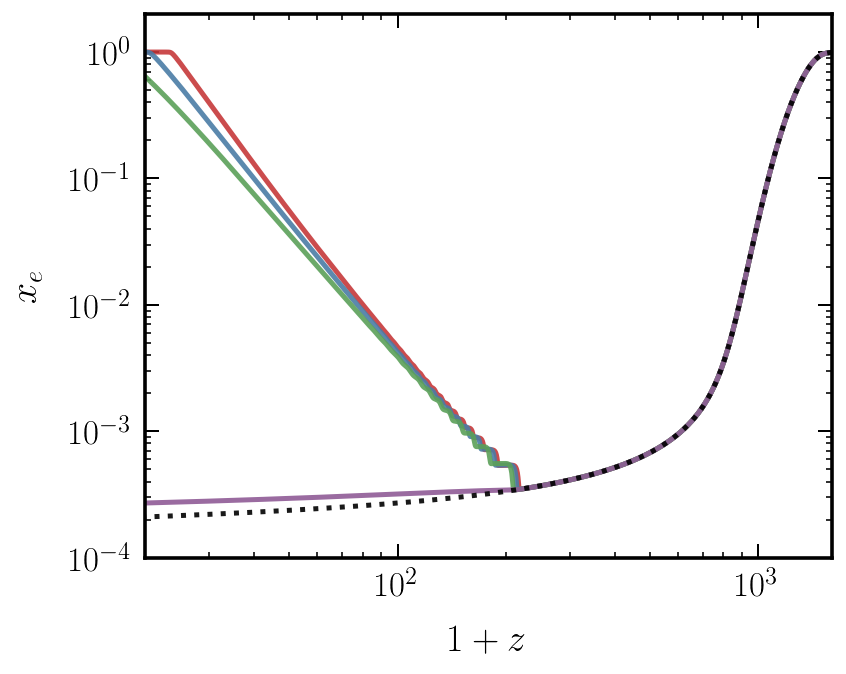

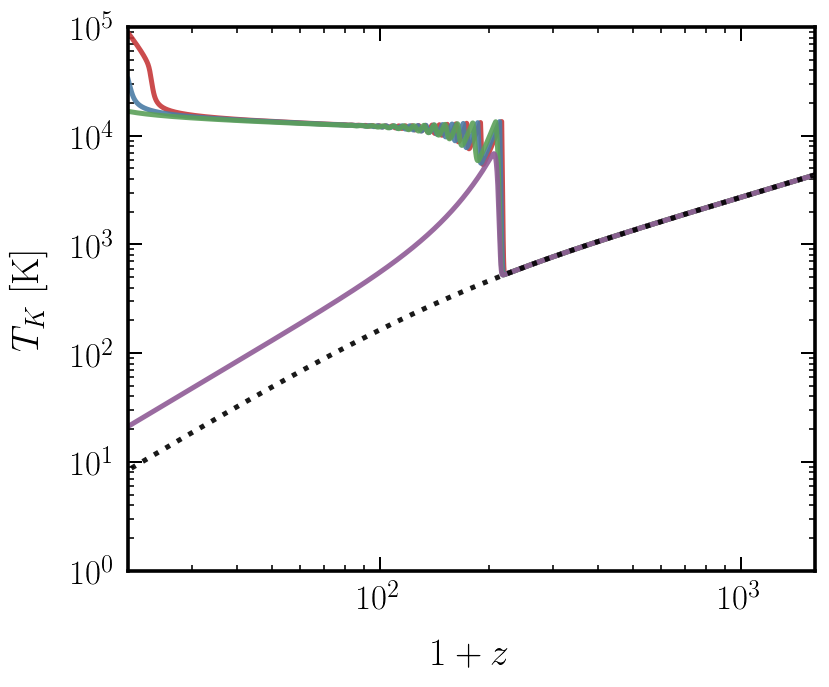

In [11]:
plt.figure()

ax2 = plt.gca()

ax2.loglog()

for soln in soln_ary:
    ax2.plot(rs_vec, soln[:,1])
    print(phys.get_optical_depth(np.flipud(rs_vec), np.flipud(soln[:,1])) - std_optical_depth)
ax2.plot(rs_vec, std[:,1], 'k:')

plt.xlabel(r'$1+z$')
plt.ylabel(r'$x_e$')

ax2.axis([20, 1600, 1e-4, 2])

plt.figure()

ax2 = plt.gca()

ax2.loglog()

for soln in soln_ary:
    ax2.plot(rs_vec, soln[:,0]/phys.kB)
ax2.plot(rs_vec, std[:,0]/phys.kB, 'k:')

plt.xlabel(r'$1+z$')
plt.ylabel(r'$T_K$ [K]')

ax2.axis([20, 1600, 1, 1e5])